<a href="https://colab.research.google.com/github/kmrakovcic/FoP_ML_workshop23/blob/master/02_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fitting

Curve fitting is a type of optimization that finds an optimal set of parameters for a defined function that best fits a given set of observations.

Unlike supervised learning, curve fitting requires that you define the function that maps examples of inputs to outputs.

The mapping function, also called the basis function can have any form you like, including a straight line (linear regression), a curved line (polynomial regression), and much more. This provides the flexibility and control to define the form of the curve, where an optimization process is used to find the specific optimal parameters of the function.

#Example 1
If I draw values from a Gaussian $N(\mu, \sigma)$, e.g. measuring quantity $\mu$
with uncertainty $\sigma$ (somewhat erroneously a.k.a. “error bar”), then the probability that the measured value will be between $x$ and $x+dx$ is:

$$ p(x) = N(\mu,\sigma) * dx $$
where:

$$ N(\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right).$$


For a sample of $N$ data points, $\{x_i\}$, where the uncertainty for each measurement is Gaussian with
a known $\sigma$, the likelihood of all N measurements is

$$L \equiv p(\{x_i\}|\mu,\sigma) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right).$$

**An important assumption** that we made here is that random noise for different
data points is independent (if it's not, we need to use methods such as Gaussian
process modeling). This assumption allowed us to simply multiply the likelihoods
for individual data points to obtain the likelihood of the whole dataset.

### Maximum Likelihood Estimation (MLE) is one of the most important methods in statistics

**MLE:** Assume that the likelihood function is given by
$$L(\mu,\sigma) \equiv p(\{x_i\}|\mu,\sigma) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right).$$

We can make use of   
$$\prod_{i=1}^n A_i \exp(-B_i) = (A_iA_{i+1}\ldots A_n) \exp[-(B_i+B_{i+1}+\ldots+B_n)]$$
and obtain
$$lnL(\mu,\sigma) \equiv ln[p(\{x_i\}|\mu,\sigma)] = const. - \frac{1}{2}\sum_{i=1}^N \frac{(x_i-\mu)^2}{\sigma^2}.$$

Text(0, 0.5, 'y')

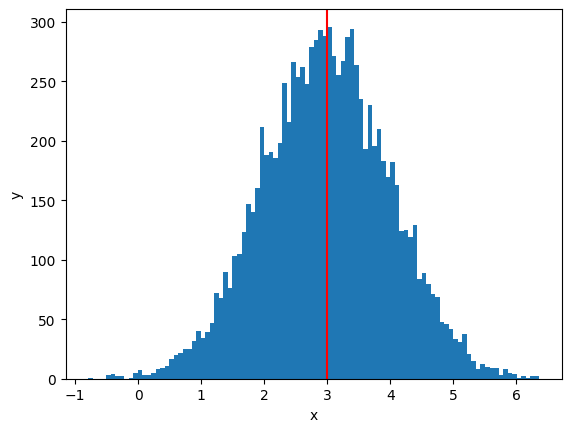

In [149]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

def generate_data_gaussian(mu, sig):
    return np.random.normal(mu, sig, 10000)

def generate_gaussian_noise(x, error):
    return x + np.random.normal(0, error, x.shape)

data = generate_data_gaussian (3, 1)
data = generate_gaussian_noise(data, 0.1)
fig, ax = plt.subplots()
ax.hist (data, bins=100)
ax.axvline (3, 0, 1, color="red")
ax.set_xlabel("x")
ax.set_ylabel("y")

#### Maximum Likelihood Estimation (MLE) applied to a Heteroscedastic Gaussian

For example, assume $N$ measurements, $\{x_i\}$, where the uncertainty for each measurement is Gaussian with
a known $\sigma_i$. The likelihood of one measurement is

$$p(x_i|\mu,\sigma_i) = \frac{1}{\sigma_i\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma_i^2}\right).$$


and therefore the likelihood of all N measurements is

$$L \equiv p(\{x_i\}|\mu,\sigma_i) = \prod_{i=1}^N \frac{1}{\sigma_i\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma_i^2}\right).$$

The more convenient log-likelihood is
$$\ln L = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2}.$$

Taking the derivative:
$$\frac{d\;{\rm lnL}(\mu)}{d\mu}\Biggr\rvert_{\mu_0} = \sum_{i=1}^N \frac{(x_i - \mu_o)}{\sigma_i^2} = 0,$$
then simplifying:

$$\sum_{i=1}^N \frac{x_i}{\sigma_i^2} = \sum_{i=1}^N \frac{\mu_o}{\sigma_i^2},$$

yields a MLE solution of
$$\mu_0 = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

with uncertainty (from the second derivative)
$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$


In case of homoscedastic uncertainties, we get the familiar expression
$$\sigma_{\mu} = \frac{\sigma}{\sqrt{N}}.$$


** Know your likelihood! **

The result for $\sigma_{\mu}$ has been derived by expanding $\ln L$ in a Taylor
series and retaining terms up to second order (essentially, the surface of $\ln L$
is approximated by a parabola, or an ellipsoidal surface in multidimensional cases,
around its maximum). If this expansion is exact (as is the case for a Gaussian error
distribution), then we've completely captured the error information (see illustration
below).

In general, this is not the case and the likelihood surface can significantly deviate
from a smooth elliptical surface. Furthermore, it often happens in practice that the
likelihood surface is multimodal. It is always a good idea to visualize the likelihood
surface when in doubt.

In [150]:
def neg_log_likelihood(x):
    def function(parm):
        mu = parm[0]
        sig = 0.1
        return np.sum((x-mu)**2/(2*sig**2))
    return function

def maximum_likelihood_estimate(x):
    return scipy.optimize.minimize(neg_log_likelihood(x), [2.5], bounds=[(0, 5)])

MLE_object = maximum_likelihood_estimate(data)
a = MLE_object.x[0]
print ("Value of a:", a)

Value of a: 2.9823870841359295


#Example 2
Given the data and the theoretical function, calculate parameters of that function.

First, we have to simulate some data. Imagine we are doing some experiment where $x$ is independent variable, and we know from theory that dependent variable that we measure must satisfy the law:
$$ y = a+b \cdot 10^{cx} $$

In reality let's say that the unknown parameters are:
* a=0.84
* b=0.34
* c=0.45

First step is to simulate the mesurements. Instead of generating perfect data, to faithfully recreate the mesuring process, a random Gaussian noise with $\sigma = 0.1$ is added.

Text(0, 0.5, 'y')

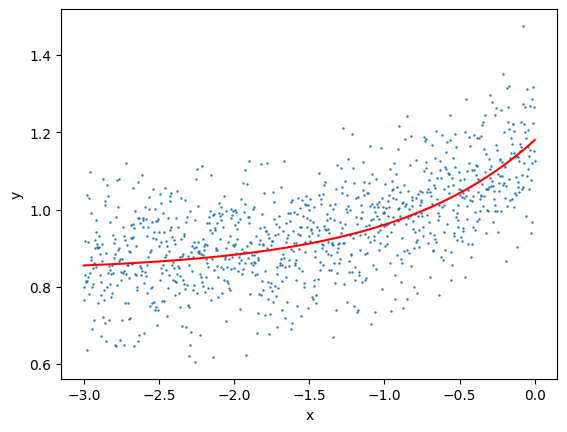

In [151]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

def data_generation (x):
    y = 0.84 + 0.34 * np.power(10, 0.45*x)
    return y+np.random.normal(0, 0.1, size=y.shape)

data_x = np.linspace (-3, 0,1000)
data_y = data_generation (data_x)
fig, ax = plt.subplots()
ax.scatter (data_x, data_y, s=0.5)
ax.plot (data_x, 0.84 + 0.34 * np.power(10, 0.45*data_x), color="red")
ax.set_xlabel("x")
ax.set_ylabel("y")

In statistics, maximum likelihood estimation (MLE) is a method of estimating the parameters of an assumed probability distribution, given some observed data. This is achieved by maximizing a likelihood function so that, under the assumed statistical model, the observed data is most probable.

Let's say that we know that some data were drawn from a Gaussian distribution, but we don't know the $\theta = (\mu,\sigma)$ values of that distribution (i.e., the parameters).

Then Maximum Likelihood Estimation method tells us to think of the likelihood as a ***function of the unknown model parameters***, and ***find those that maximize the value of $L$***. Those will be our Maximum Likelihood Estimators for for the true values of the model.

For a sample of $N$ data points, $\{x_i\}$, where the uncertainty for each measurement is Gaussian with
a known $\sigma$, the likelihood of all N measurements is

$$L \equiv p(\{x_i\}|\mu,\sigma) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right).$$

Keep in mind that $\mu$ here is a function we are trying to fit, $\mu = \mu (a,b,c)$. If we calculate logarithm of likelihood we get:
$$ \ln{L} = \sum_{i=1}^N \frac{-(x_i-\mu)^2}{2\sigma^2} \ln{\left(\frac{1}{\sigma\sqrt{2\pi}} \right)} $$
Under assumtion that all the mesurements are done with same uncertanty:
$$ \ln{L} = \left[ \frac{1}{2\sigma^2} \ln{\left(\frac{1}{\sigma\sqrt{2\pi}} \right)}\right]^N \sum_{i=1}^N -(x_i-\mu)^2$$

If we maximize that function actually we are maximizing:
$$ \ln{L} = - \sum_{i=1}^N (x_i-\mu)^2$$

Additionally for computational reasons, instead of maximizing, it is always better to minimize negative log likelihood:
$$ -\ln{L} = \sum_{i=1}^N (x_i-\mu)^2$$

In the machine learning this function is usually called **Mean square error** (MSE)

In [152]:
def teoretical_function(x, a, b, c):
    return a + b * np.power(10, c*x)

def neg_log_likelihood(x, y):
    def function(parm):
        a = parm[0]
        b = parm[1]
        c = parm[2]
        mu = a + b * np.power(10, c*x)
        return np.sum((y-mu)**2)
    return function

def maximum_likelihood_estimate(x, y):
    return scipy.optimize.minimize(neg_log_likelihood(x, y), [0.5, 0.5, 0.5], bounds=[(0, 1), (0, 1), (0, 1)])

MLE_object = maximum_likelihood_estimate(data_x, data_y)
a, b, c = MLE_object.x
print ("Value of a:", a)
print ("Value of b:", b)
print ("Value of c:", c)

Value of a: 0.8477473887259093
Value of b: 0.3233565354198602
Value of c: 0.43471480109546584


How to get uncertanty estimates? Usual way is to use inverse hessian object, that on its diagonal has $\sigma$ values for all the parameters. Be aware this method is easy although it may not always work!

In [153]:
inv_hess = MLE_object.hess_inv.todense()
print (inv_hess)
print ("Value of a:", a, "+-", inv_hess[0,0])
print ("Value of b:", b, "+-", inv_hess[1,1])
print ("Value of c:", c, "+-", inv_hess[2,2])

[[ 0.11600146 -0.07627349  0.36662536]
 [-0.07627349  0.05636865 -0.23146264]
 [ 0.36662536 -0.23146264  1.18654913]]
Value of a: 0.8477473887259093 +- 0.11600145783502809
Value of b: 0.3233565354198602 +- 0.05636864640330034
Value of c: 0.43471480109546584 +- 1.1865491279684637


To plot the best fit and the data:

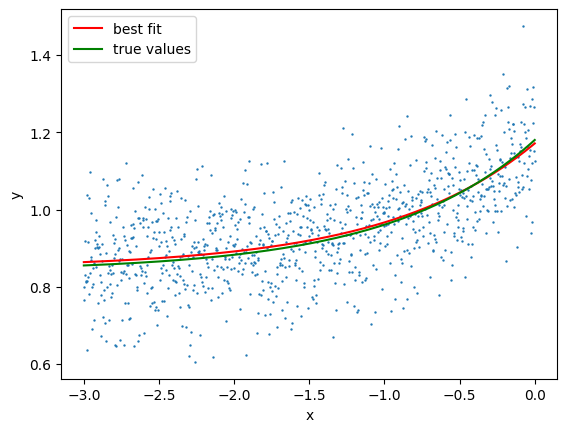

In [154]:
fig, ax = plt.subplots()
ax.scatter (data_x, data_y, s=0.5)
ax.plot (data_x, teoretical_function(data_x, a, b, c), color="red", label="best fit")
ax.plot (data_x, 0.84 + 0.34 * np.power(10, 0.45*data_x), color="green", label="true values")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.legend()

## Solution 2
There is another way to sove this problem. We can use curve_fit function from SciPy library.

In [155]:
parameters, error = scipy.optimize.curve_fit(teoretical_function, data_x, data_y)
print ("Value of a:", parameters[0], "+-", error[0,0])
print ("Value of b:", parameters[1], "+-", error[1,1])
print ("Value of c:", parameters[2], "+-", error[2,2])

Value of a: 0.8477481940035433 +- 0.00014190654282195215
Value of b: 0.32335585595668903 +- 0.00015631437951366578
Value of c: 0.43471680177927424 +- 0.0026889478042941392


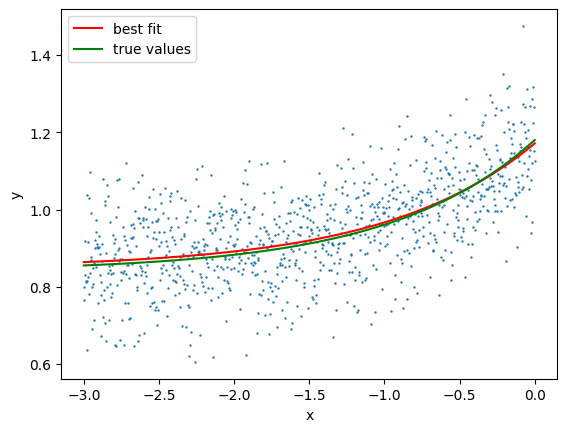

In [156]:
fig, ax = plt.subplots()
ax.scatter (data_x, data_y, s=0.5)
ax.plot (data_x, teoretical_function(data_x, parameters[0], parameters[1], parameters[2]), color="red", label="best fit")
ax.plot (data_x, 0.84 + 0.34 * np.power(10, 0.45*data_x), color="green", label="true values")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.legend()

#Excercise 1



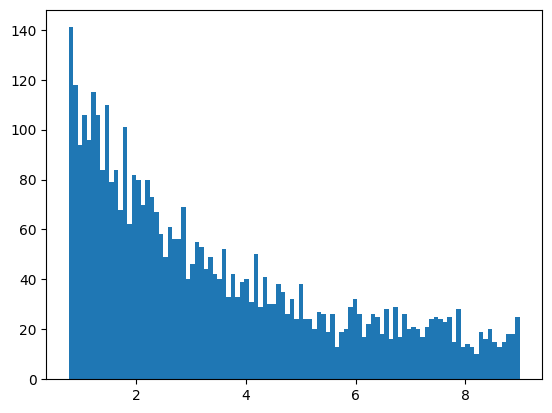

In [157]:
import pandas as pd
import numpy as np
data = np.array(pd.read_csv('/content/Muon_decay_data.csv'))
lower_cutoff=0.75
higher_cutoff=9
data = data[np.logical_and(data < higher_cutoff, data > lower_cutoff)]
fig, ax = plt.subplots()
histogram = ax.hist(data, bins=100)

In [158]:
#@title My solution
# Write code here

w =  0.6381157071759012 +- 0.0156
tau =  2.072931492779834 +- 0.07060000000000002


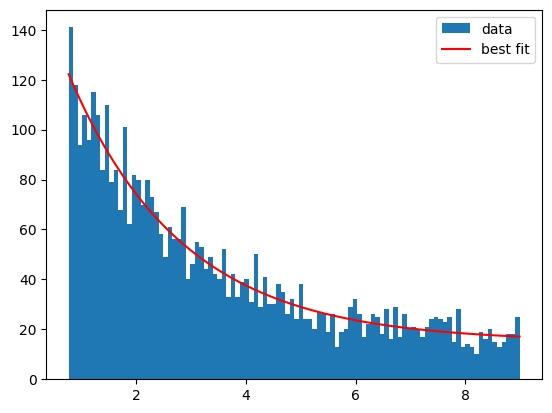

In [159]:
#@title Solution:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt


def neg_log_likelihood(x, lower_cutoff=0.75, higher_cutoff=9):
    """
    Function to calculate the negative log likelihood of the data given the parameters w and tau.
    :param x:
    :param lower_cutoff:
    :param higher_cutoff:
    :return:
    """
    def function(parm):
        """
        Function to calculate the negative log likelihood of the data given the parameters w and tau.
        :param parm:
        :return:
        """
        w = parm[0]
        tau = parm[1]
        y = w * 1/tau * 1/(np.exp(-lower_cutoff/tau)-np.exp(-higher_cutoff/tau)) * np.exp(-x/tau) + (1-w) * 1/(higher_cutoff-lower_cutoff)
        if np.any(y <= 0):
            return 1e10
        else:
            return -np.sum(np.log(y))
    return function


def exp_function(x, w, tau, lower_cutoff, higher_cutoff):
    """
    Function to calculate the data distribution model given the parameters w and tau.
    :param x:
    :param w:
    :param tau:
    :param lower_cutoff:
    :param higher_cutoff:
    :return:
    """
    y = w * 1/tau * 1/(np.exp(-lower_cutoff/tau)-np.exp(-higher_cutoff/tau)) * np.exp(-x/tau) + (1-w) * 1/(higher_cutoff-lower_cutoff)
    return y


def estimate_standard_deviation(data, params, lower_cutoff=0.75, higher_cutoff=9):
    """
    Estimate the standard deviation of the parameters using the fact that the likelihood function is a parabola
    around the maximum likelihood estimate. The standard deviation is the distance from the maximum likelihood
    estimate to the point where the likelihood function is 0.5 below the maximum likelihood estimate.
    :param data:
    :param params:
    :param lower_cutoff:
    :param higher_cutoff:
    :return:
    """
    likelihood = neg_log_likelihood(data, lower_cutoff, higher_cutoff)
    init_like = likelihood(params)
    p_err = np.zeros(len(params))
    for i,parameter in enumerate(params):
        for k in range(-1, 5):
            continue_l = True
            while continue_l:
                new_params = np.zeros(len(params))
                new_params[i] = p_err[i] + 10 ** (-k)
                new_params = new_params + params
                p_like = likelihood(new_params)
                if (p_like - init_like) >= 0.5 or np.isnan(p_like - init_like) or p_err[i] > 10:
                    continue_l = False
                else:
                    p_err[i] += 10 ** (-k)
    return p_err


def maximum_likelihood_estimate(data, lower_cutoff, higher_cutoff):
    """
    Function to calculate the maximum likelihood estimate of the parameters w and tau.
    :param data:
    :param lower_cutoff:
    :param higher_cutoff:
    :return:
    """
    data = data[np.logical_and(data < higher_cutoff, data > lower_cutoff)]
    popt = scipy.optimize.minimize(neg_log_likelihood(data, lower_cutoff, higher_cutoff), [0.75, 2], bounds=[(0, 1), (1, 3)])
    values = popt.x
    errors = estimate_standard_deviation(data, values, lower_cutoff, higher_cutoff)
    return values, errors


def fit_and_calculate_histogram(data, n_bins, lower_cutoff=0.75, higher_cutoff=9):
    """
    Function to calculate the histogram of the data and fit the data distribution model to the histogram.
    :param data:
    :param n_bins:
    :param lower_cutoff:
    :param higher_cutoff:
    :return:
    """
    [w, tau], [w_err, tau_err] = maximum_likelihood_estimate(data, lower_cutoff, higher_cutoff)
    return w, tau, w_err, tau_err


[w, tau], [w_err, tau_err] = maximum_likelihood_estimate(data, lower_cutoff=0.75, higher_cutoff=9)
fig, ax = plt.subplots()
histogram = ax.hist(data, bins=100, label="data")
bins = histogram[1]
fit = ax.plot (bins, exp_function(bins, w, tau, lower_cutoff=0.75, higher_cutoff=9)*(bins[1] - bins[0])*data.shape, color="red", label="best fit")
plt.legend()
print ("w = ", w, "+-", w_err)
print ("tau = ", tau, "+-", tau_err)